In [3]:
from google.colab import files

# Upload kaggle.json from your computer
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
!pip install kaggle --quiet

# Use the slug from your link
!kaggle datasets download -d lainguyn123/student-performance-factors --quiet
!unzip student-performance-factors.zip >/dev/null


Dataset URL: https://www.kaggle.com/datasets/lainguyn123/student-performance-factors
License(s): CC0-1.0


In [31]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [23]:
# Load data
df = pd.read_csv('/content/StudentPerformanceFactors.csv')
print("\nData Preview:")
display(df.head(3))
print("\nData Summary:")
display(df.describe())


Data Preview:


,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74



Data Summary:


,Hours_Studied,Attendance,Sleep_Hours,Previous_Scores,Tutoring_Sessions,Physical_Activity,Exam_Score
count,6607.000000,6607.000000,6607.00000,6607.000000,6607.000000,6607.000000,6607.000000
mean,19.975329,79.977448,7.02906,75.070531,1.493719,2.967610,67.235659
std,5.990594,11.547475,1.46812,14.399784,1.230570,1.031231,3.890456
min,1.000000,60.000000,4.00000,50.000000,0.000000,0.000000,55.000000
25%,16.000000,70.000000,6.00000,63.000000,1.000000,2.000000,65.000000
50%,20.000000,80.000000,7.00000,75.000000,1.000000,3.000000,67.000000
75%,24.000000,90.000000,8.00000,88.000000,2.000000,4.000000,69.000000
max,44.000000,100.000000,10.00000,100.000000,8.000000,6.000000,101.000000


In [32]:
# 4. Missing values check
print("\nMissing Values Before Imputation:")
print(df.isnull().sum())


Missing Values Before Imputation:
Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64


In [33]:
# Identify numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

In [34]:
# Fill missing values
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

df[numeric_cols] = imputer_num.fit_transform(df[numeric_cols])
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

print("\nMissing Values After Imputation:")
print(df.isnull().sum())


Missing Values After Imputation:
Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64


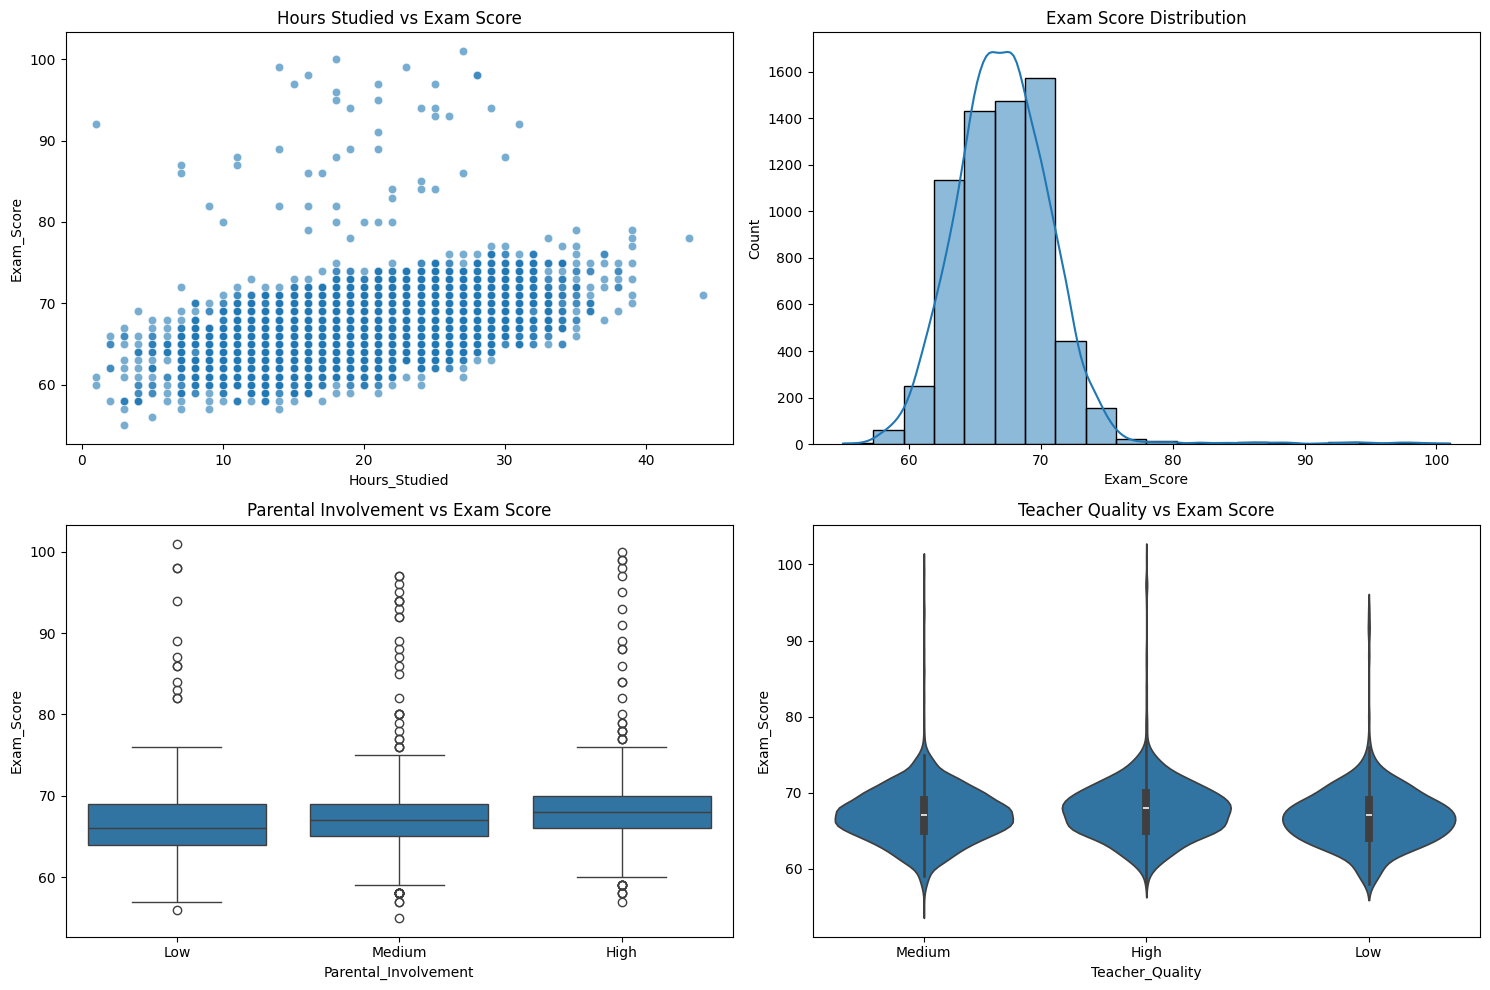

In [36]:

# 5. Basic visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='Hours_Studied', y='Exam_Score', data=df, alpha=0.6)
plt.title('Hours Studied vs Exam Score')

plt.subplot(2, 2, 2)
sns.histplot(df['Exam_Score'], bins=20, kde=True)
plt.title('Exam Score Distribution')

plt.subplot(2, 2, 3)
sns.boxplot(x='Parental_Involvement', y='Exam_Score', data=df)
plt.title('Parental Involvement vs Exam Score')

plt.subplot(2, 2, 4)
sns.violinplot(x='Teacher_Quality', y='Exam_Score', data=df)
plt.title('Teacher Quality vs Exam Score')

plt.tight_layout()
plt.show()

In [37]:
# 6. Feature selection (more features to improve R²)
features = [
    'Hours_Studied', 'Previous_Scores', 'Teacher_Quality',
    'Parental_Involvement', 'Sleep_Hours', 'Distance_from_Home',
    'Attendance', 'Access_to_Resources', 'Family_Income',
    'Peer_Influence', 'Physical_Activity'
]

X = df[features]
y = df['Exam_Score']

# Separate numeric and categorical features
num_feats = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_feats = X.select_dtypes(include=['object']).columns.tolist()

# Preprocess: scale numeric + one-hot encode categorical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(drop='first'), cat_feats)
])

In [38]:
# 7. Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [39]:
# 8. Linear Regression
print("\n## Linear Regression Results:")
linear_model = make_pipeline(preprocessor, LinearRegression())
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Mean Squared Error: {mse_linear:.2f}")
print(f"R-squared: {r2_linear:.4f}")


## Linear Regression Results:
Mean Squared Error: 3.97
R-squared: 0.7194


In [40]:
# 9. Polynomial Regression
print("\n## Polynomial Regression Results:")
poly_model = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2),
    LinearRegression()
)
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print(f"Mean Squared Error: {mse_poly:.2f}")
print(f"R-squared: {r2_poly:.4f}")


## Polynomial Regression Results:
Mean Squared Error: 4.13
R-squared: 0.7076


In [41]:
# 10. Compare results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression'],
    'MSE': [mse_linear, mse_poly],
    'R-squared': [r2_linear, r2_poly]
})

print("\n## Model Comparison:")
print(results)


## Model Comparison:
                   Model       MSE  R-squared
0      Linear Regression  3.966767   0.719367
1  Polynomial Regression  4.132764   0.707623


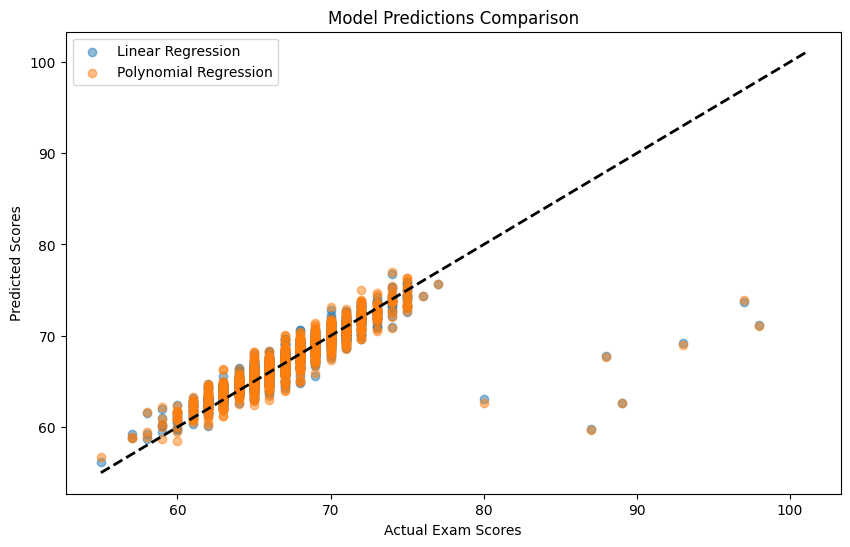

In [42]:
# 11. Prediction visualization
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_linear, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, y_pred_poly, alpha=0.5, label='Polynomial Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Exam Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions Comparison')
plt.legend()
plt.show()

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# One Hot Encoding
X_train_enc = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# Feature sets (based on encoded data)
feature_sets = {
    "All Features": X_train_enc.columns.tolist(),
    "Without Sleep & Extra": [col for col in X_train_enc.columns if "Sleep_Hours" not in col and "Extracurricular_Activities" not in col],
    "Study Hours + Previous Scores": [col for col in X_train_enc.columns if "Hours_Studied" in col or "Previous_Scores" in col]
}

results = []

for name, features in feature_sets.items():
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train_enc[features], y_train)
    y_pred_lr = lr.predict(X_test_enc[features])

    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)

    # Polynomial Regression
    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train_enc[features])
    X_test_poly = poly.transform(X_test_enc[features])

    pr = LinearRegression()
    pr.fit(X_train_poly, y_train)
    y_pred_pr = pr.predict(X_test_poly)

    mse_pr = mean_squared_error(y_test, y_pred_pr)
    r2_pr = r2_score(y_test, y_pred_pr)

    results.append([name, "Linear", mse_lr, r2_lr])
    results.append([name, "Polynomial", mse_pr, r2_pr])

# Show results
results_df = pd.DataFrame(results, columns=["Feature_Set", "Model", "MSE", "R2"])
print(results_df)


                     Feature_Set       Model        MSE        R2
0                   All Features      Linear   3.966767  0.719367
1                   All Features  Polynomial   4.132764  0.707623
2          Without Sleep & Extra      Linear   3.962747  0.719651
3          Without Sleep & Extra  Polynomial   4.122566  0.708345
4  Study Hours + Previous Scores      Linear  10.543769  0.254070
5  Study Hours + Previous Scores  Polynomial  10.528229  0.255170
